In [63]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import sys
sys.path.append("..")
from tqdm.notebook import tqdm
from numba import jit
from scipy import stats

plt.style.use("../config/custom_plt.mplstyle")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
COLORS = ["purple", "orange", "blue", "tan", "red", "teal", "orange", "black", "goldenrod"]
COLORS = ["xkcd:" + c for c in COLORS]


COLORS = ['#2D1E2F', '#F7B32B', '#21A179', '#8E7DBE', '#F72C25']

def load_files(path, filename, ext):
    df = pd.read_csv(f"{path}/{filename}.{ext}", sep="\s+")
    return df

def load_vprops(path, filename):
    return load_files(path, filename, 'inf_vprop')

def load_vstats(path, filename):
    return load_files(path, filename, 'inf_vstat')

def load_vstat_obs(path, filename):
    return load_files(path, filename, 'obs_vstat')

def load_pcon(path, filename):
    df = pd.read_csv(f"{path}/{filename}.inf_pconn", sep="\s+", comment="#")
    df.columns = ["RescaledDist", "InfConnProb", "ThConnProb"]
    return df

In [65]:
MARKERS = ['o']

def plot_vstats(df_obs, df_vstats, x1_col, y1_col, x2_col, y2_col, y2err_col, xlabel, ylabel, labels):
    x1, y1 = df_obs[x1_col], df_obs[y1_col]    
    plt.plot(x1, y1, color=COLORS[0], label="Data", marker=MARKERS[0], ms=6, linewidth=1, alpha=0.8)
        
    for i, df_vstat in enumerate(df_vstats):
        x2, y2, y2err = df_vstat[x2_col], df_vstat[y2_col], df_vstat[y2err_col]
        
        plt.plot(x2, y2, color=COLORS[i+1], alpha=0.8, label=labels[i])
        plt.fill_between(x2, y2 - y2err, y2 + y2err, color=COLORS[i+1], alpha=0.3)
        
    plt.yscale('log')
    plt.xscale('log')
    plt.legend(fontsize=18, frameon=False, loc='lower left')
    plt.xlabel(xlabel, fontsize=22)
    plt.ylabel(ylabel, fontsize=22)
    
    
def plot_degree_distribution(df_obs, df_vstats, labels):
    plot_vstats(df_obs, df_vstats, "#", "DegDist", "#", "DegDistEnsStd", "CDegDistEns", 
                r"$k$", r"$P_c(k)$", labels)
    
def plot_clustering_coefficient(df_obs, df_vstats, labels):
    plot_vstats(df_obs, df_vstats, "#", "NbTriang", "#", "NbTriangEnsStd", "ClustEns", 
                r"$k$", r"$\bar{c}(k)$", labels)
    plt.xlim(1.9, 500)
    plt.yscale('linear')
    
    
def plot_number_of_triangles(df_vprops, labels):
    for i, df_vprop in enumerate(df_vprops):
        obs = df_vprop.iloc[:, 10]
        inf = df_vprop.iloc[:, 11]
        inf_err = df_vprop.iloc[:, 12]

        plt.scatter(obs, inf, color=COLORS[i+1], label=labels[i], alpha=0.4, marker='.')
    
    xx = range(1, max(obs))
    plt.plot(xx, xx, linewidth=2, linestyle='--', color='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('inferred number of triangles', fontsize=20)
    plt.xlabel('original number of triangles', fontsize=20)

def plot_sum_degree_neighbours(df_vprops, labels):
    for i, df_vprop in enumerate(df_vprops):
        obs = df_vprop.iloc[:, 7]
        inf = df_vprop.iloc[:, 8]
        inf_err = df_vprop.iloc[:, 9]

        plt.scatter(obs, inf, color=COLORS[i+1], label=labels[i], alpha=0.4, marker='.')
        
    xx = range(int(min(obs)), int(max(obs)))
    plt.plot(xx, xx, linewidth=2, linestyle='--', color='black')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('inferred average degree of neighbors', fontsize=20)
    plt.xlabel('original average degree of neighbors', fontsize=20)

def plot_connection_probabilities(df_pconns, labels):
    for i, df in enumerate(df_pconns):
        non_zeros = np.where(df.InfConnProb.values != 0)
        x = df.RescaledDist.values[non_zeros]
        y = df.InfConnProb.values[non_zeros]
        plt.plot(x, y, color=COLORS[i+1], label=labels[i])
        plt.plot(df.RescaledDist, df.ThConnProb, color=COLORS[i+1], linestyle='--', label='expected')

    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-6, 3)
    plt.ylabel("probability of connection")
    plt.xlabel(r"rescaled distance ($\chi$)")
    plt.legend()
    
def plot_average_degree_neighbour(df_obs, df_vstats, labels):
    plot_vstats(df_obs, df_vstats, "#", "SumDegN", "#", "SumDegNEnsStd", "AvgDegNEns", 
                r"$k$", r"$\bar{k}_{nn}(k)$", labels)
    plt.yscale('linear')

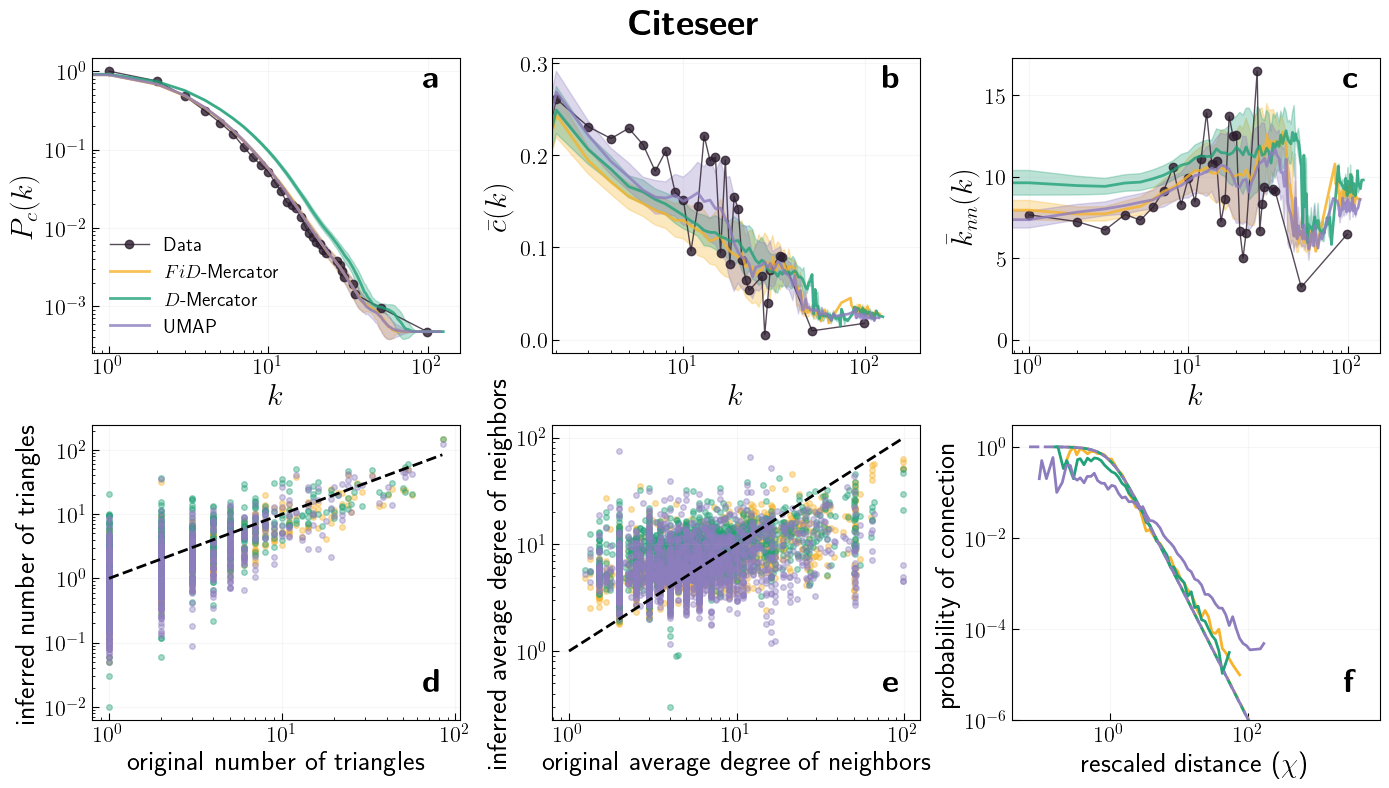

In [66]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/only_umap/"
#path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/random/"

filename = 'citeseer_GC_fixed'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Citeseer}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_citeseer_new.png", dpi=300)



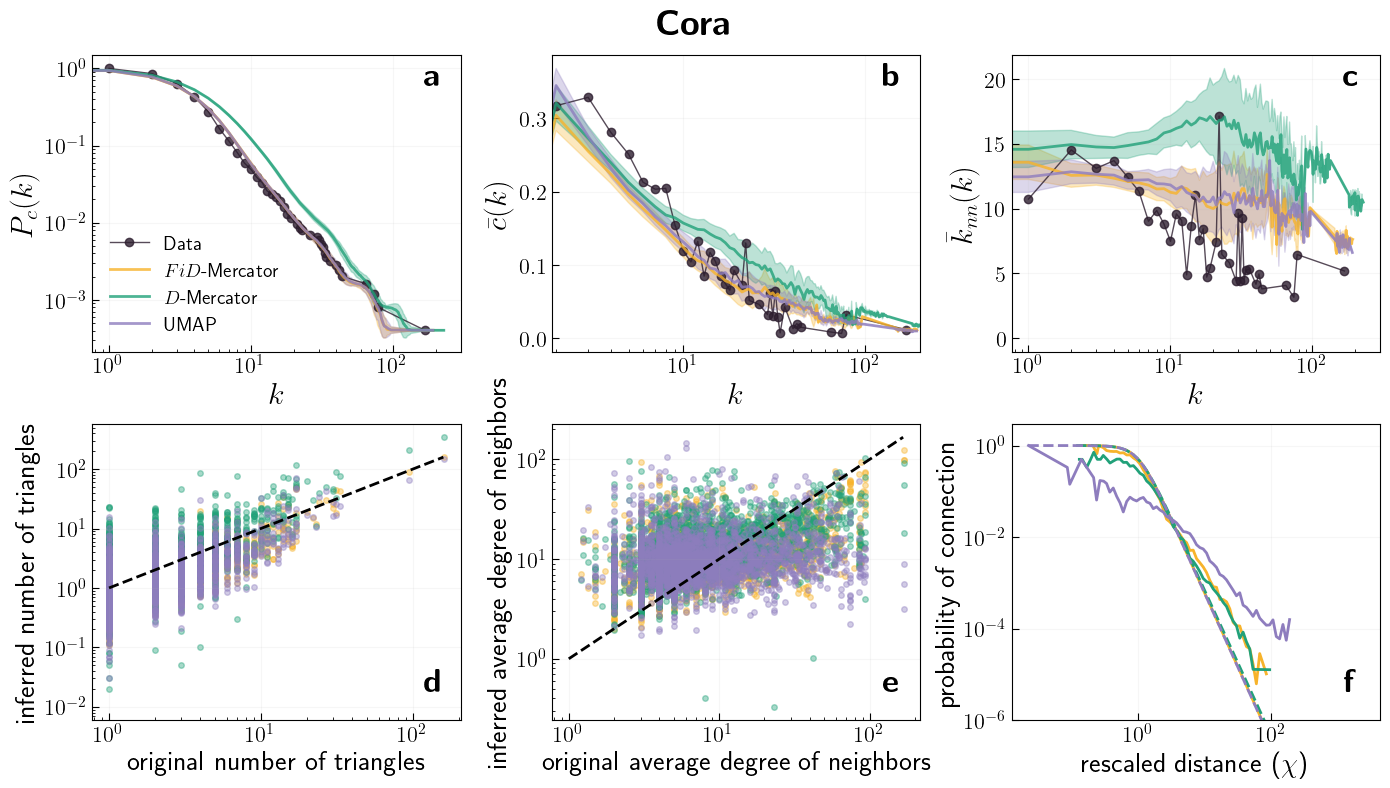

In [67]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/random/"

filename = 'cora_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Cora}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_cora_new.png", dpi=300)


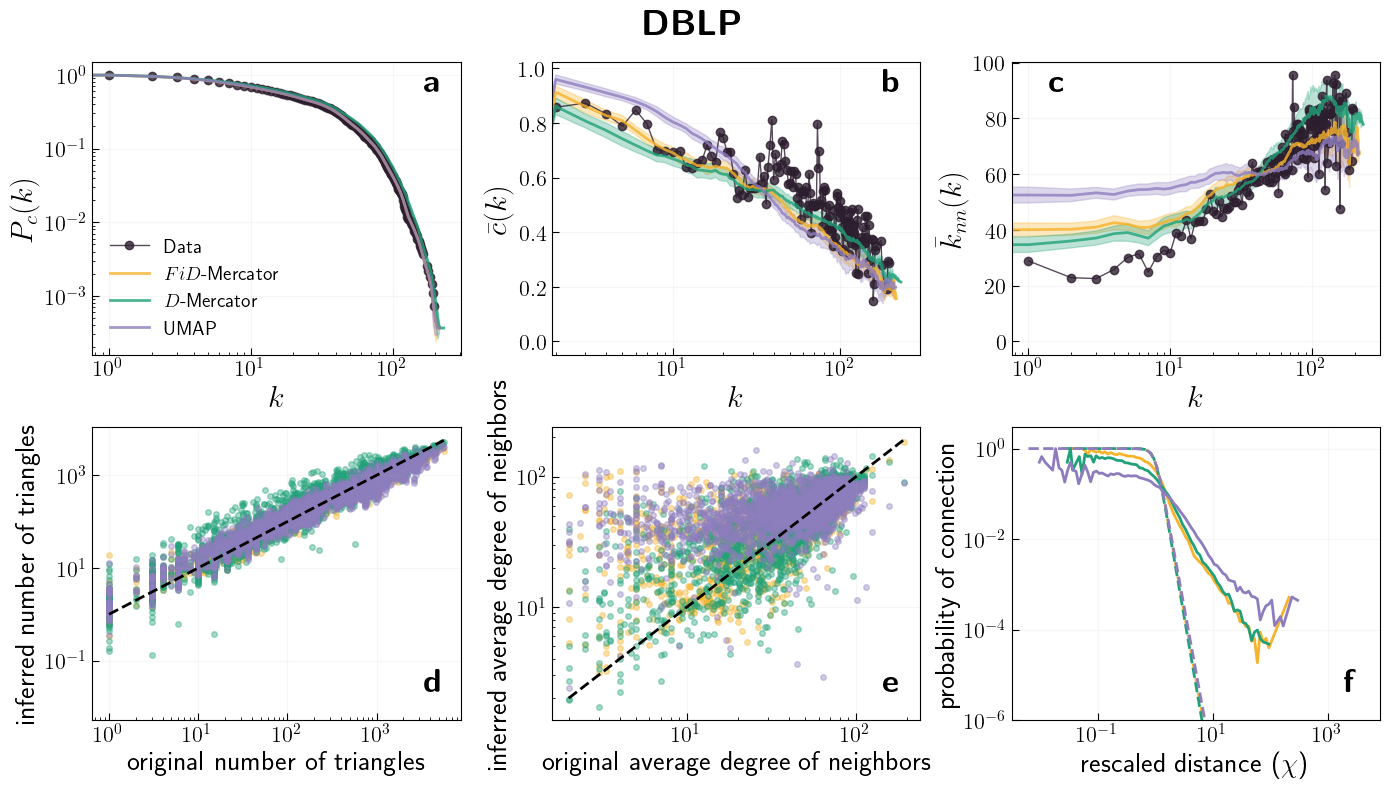

In [68]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/random/"

filename = 'dblp_pprefp_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 300)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.1, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{DBLP}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_dblp_new.png", dpi=300)


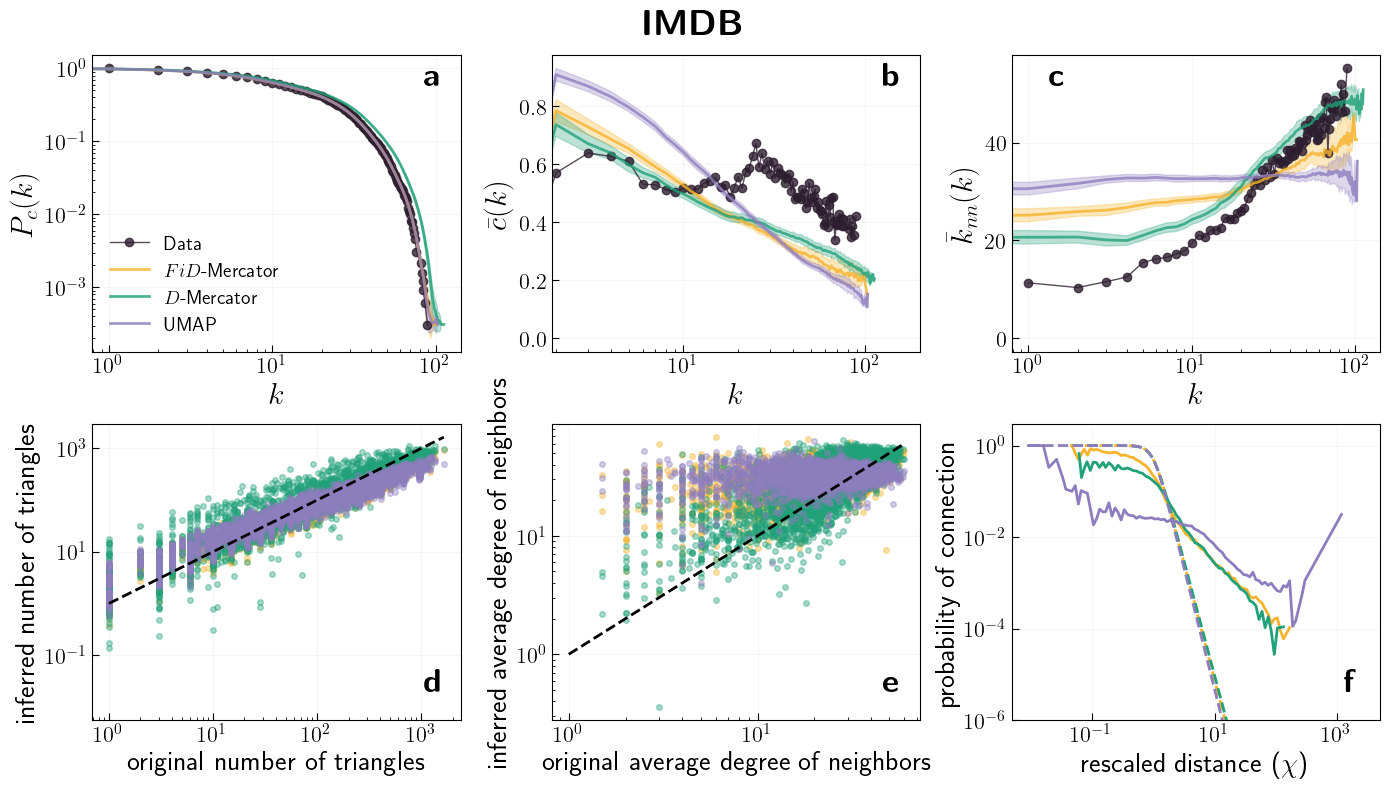

In [69]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/random/"

filename = 'imdb_mam_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.1, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{IMDB}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_imdb_new.png", dpi=300)


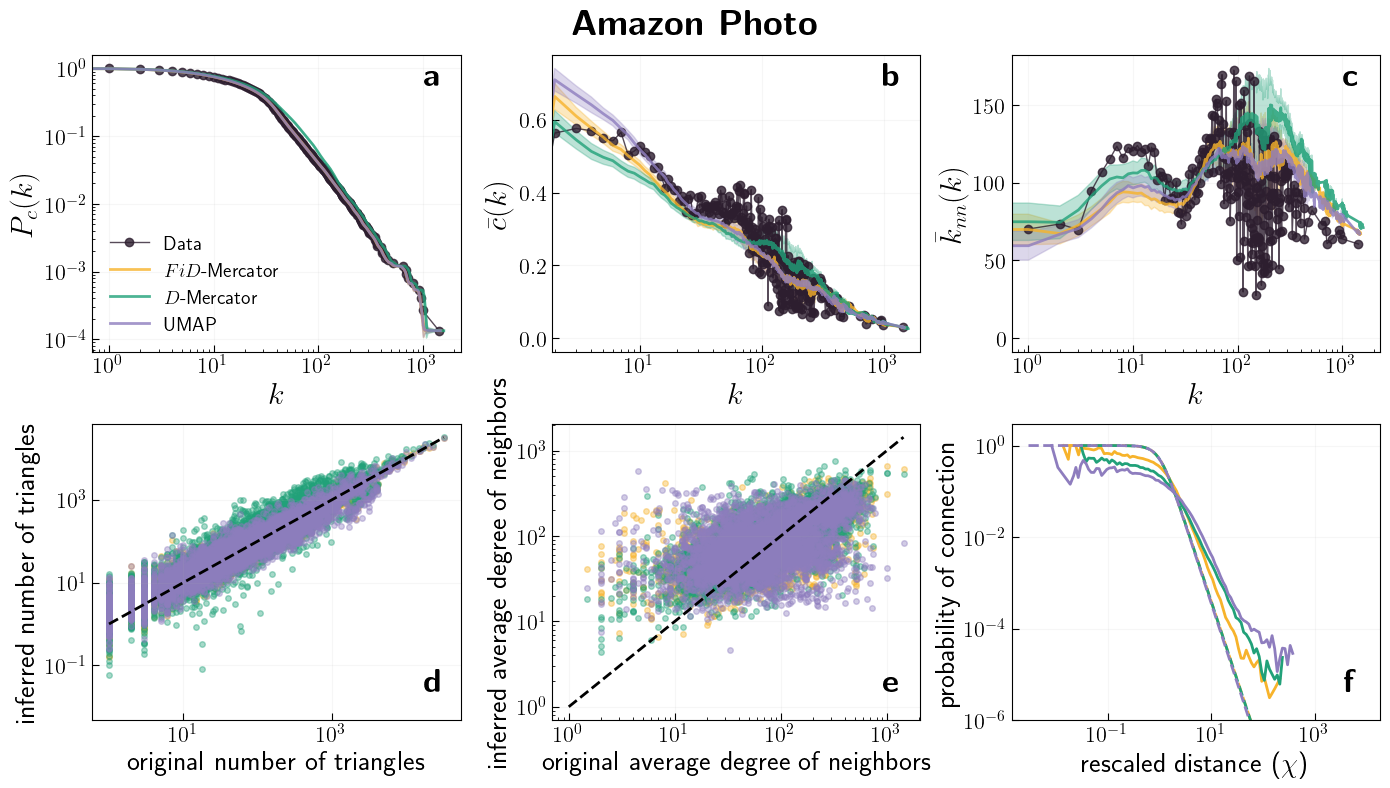

In [70]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/random/"

filename = 'amazon_photo_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 2000)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Amazon Photo}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/plots/topological_properties_amazon_photo_new.png", dpi=300)
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_amazon_photo_new.png", dpi=300)



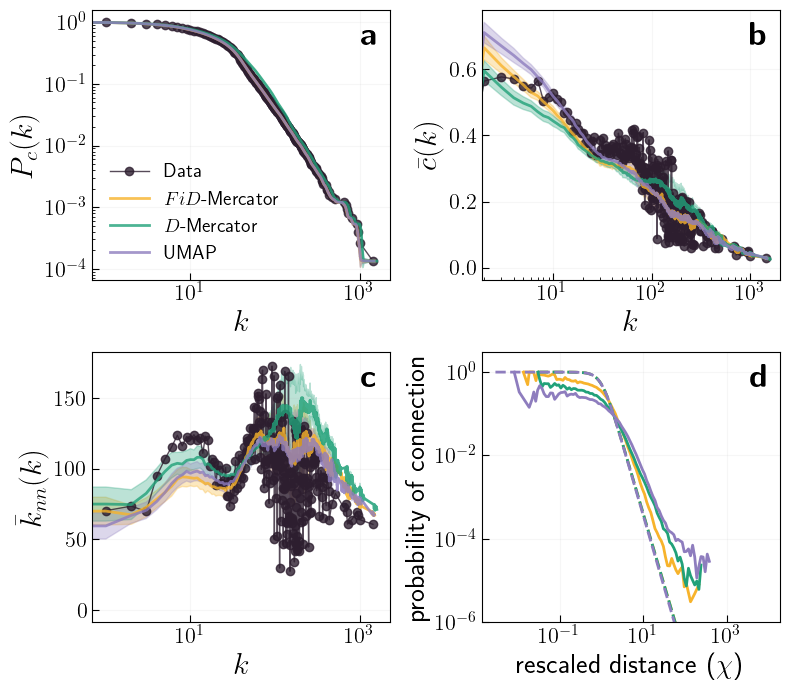

In [80]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/random/"

filename = 'amazon_photo_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.87, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 2000)
plt.text(0.9, 0.87, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 2, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.87, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 2, 4)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.87, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

# plt.suptitle(r'\textbf{Amazon Photo}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/plots/topological_properties_amazon_photo_new.png", dpi=300)
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_amazon_photo_new.png", dpi=300)


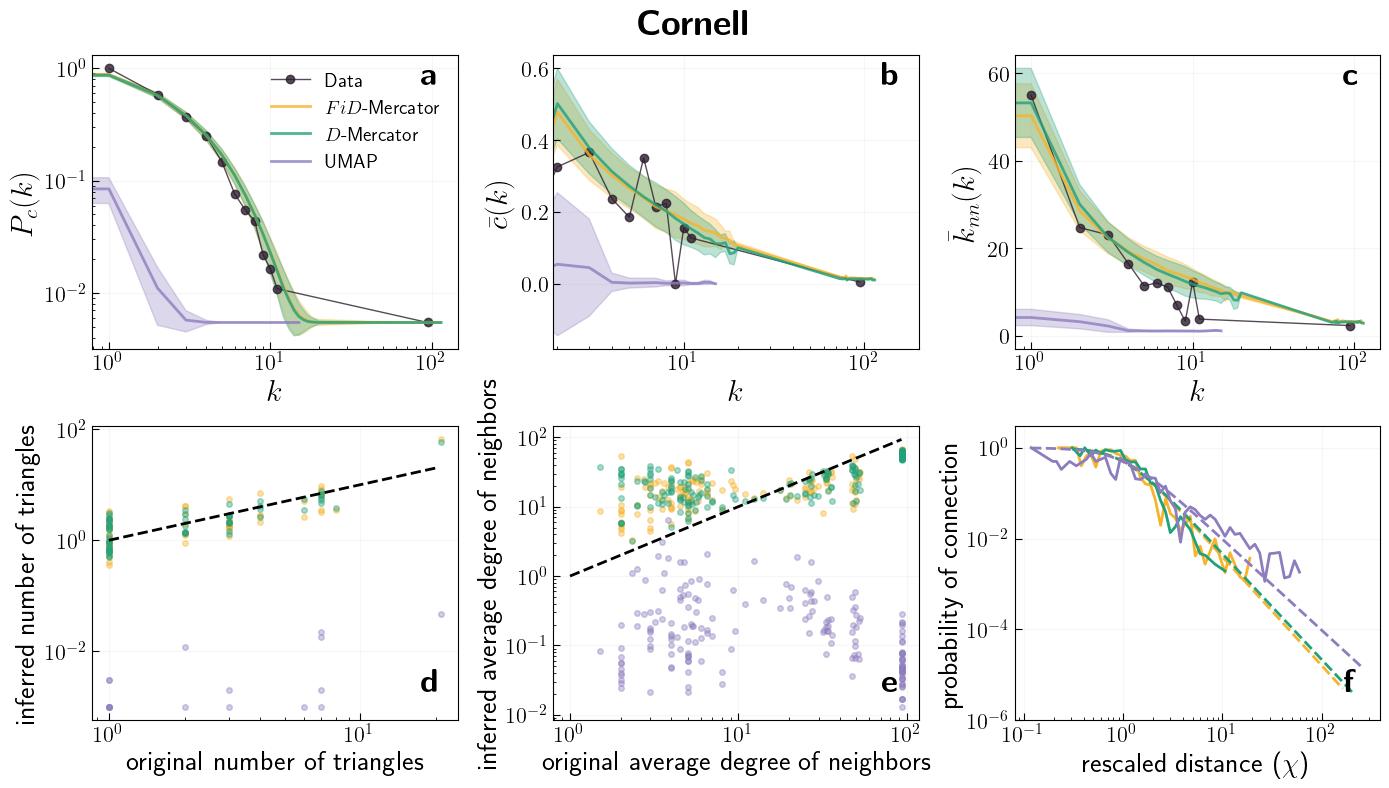

In [71]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/random/"

filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Cornell}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_cornell_new.png", dpi=300)


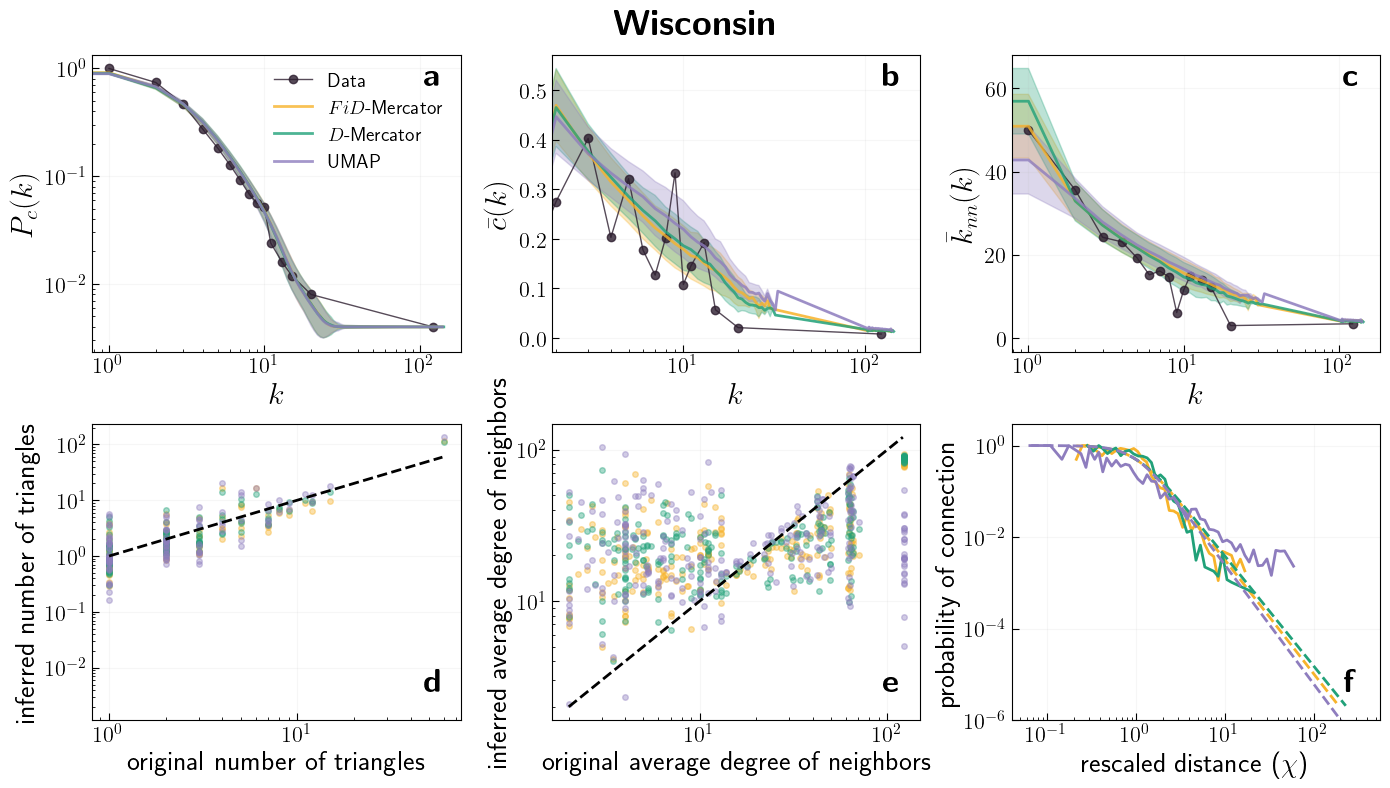

In [72]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/random/"

filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Wisconsin}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_wisconsin_new.png", dpi=300)


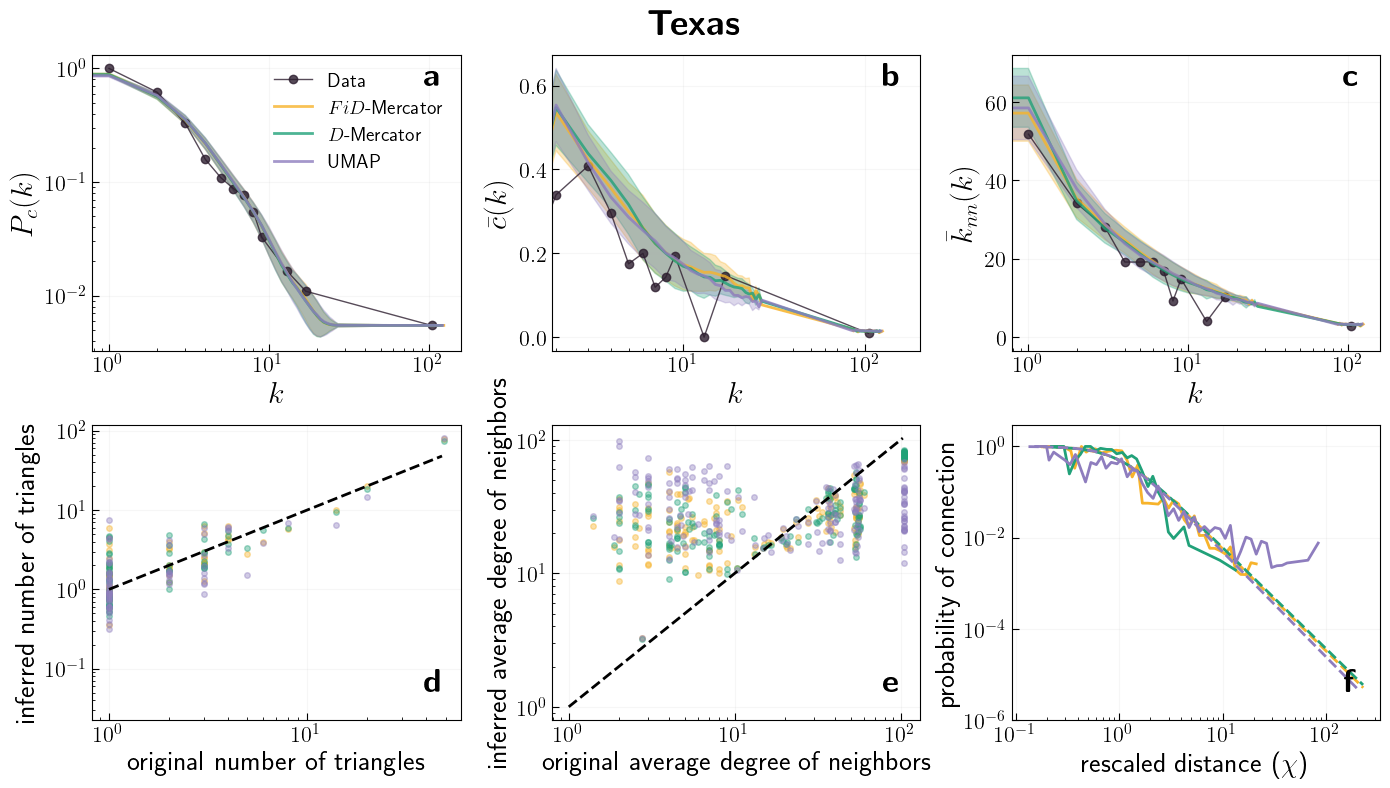

In [73]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/random/"

filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Texas}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_texas_new.png", dpi=300)


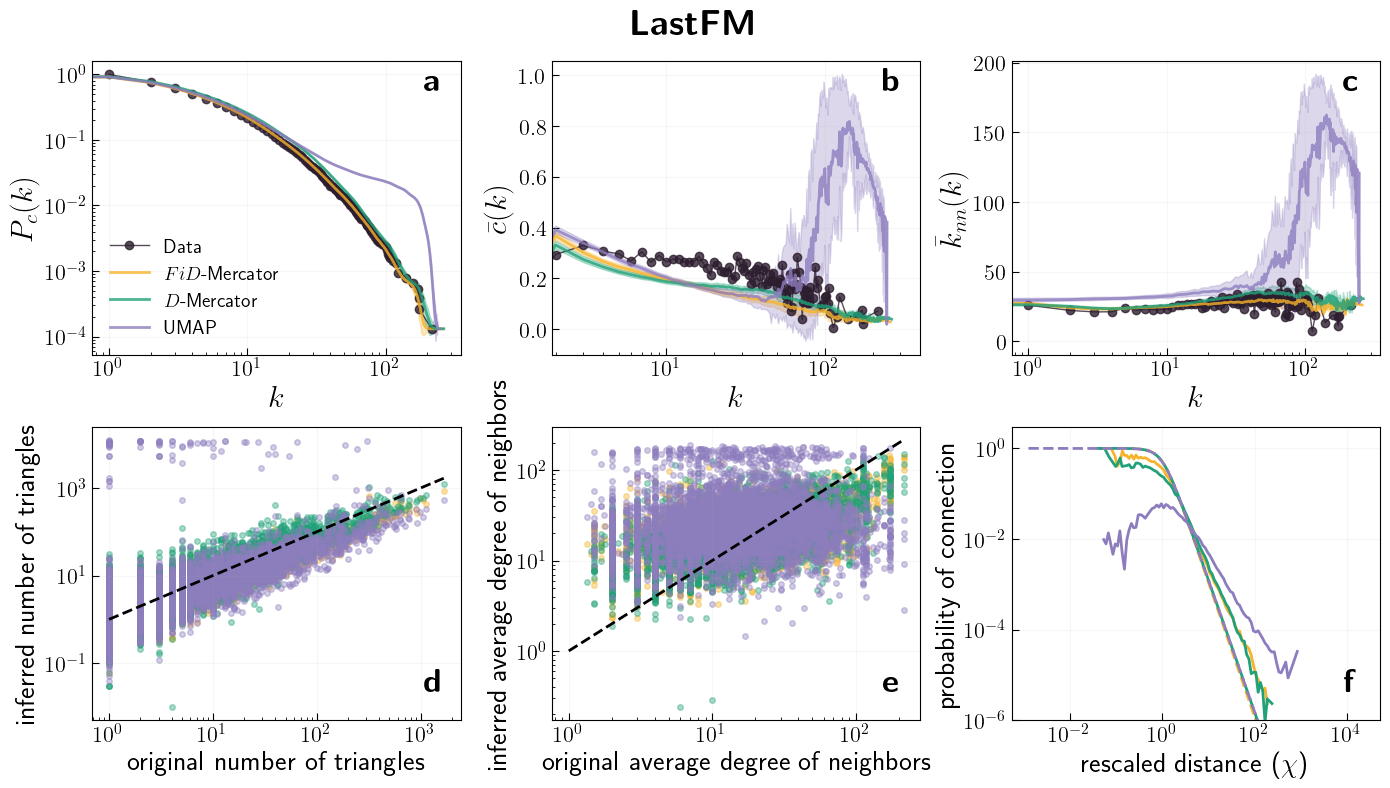

In [59]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/random/"

filename = 'lastfm_asia_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 400)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{LastFM}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_lastfm_new.png", dpi=300)


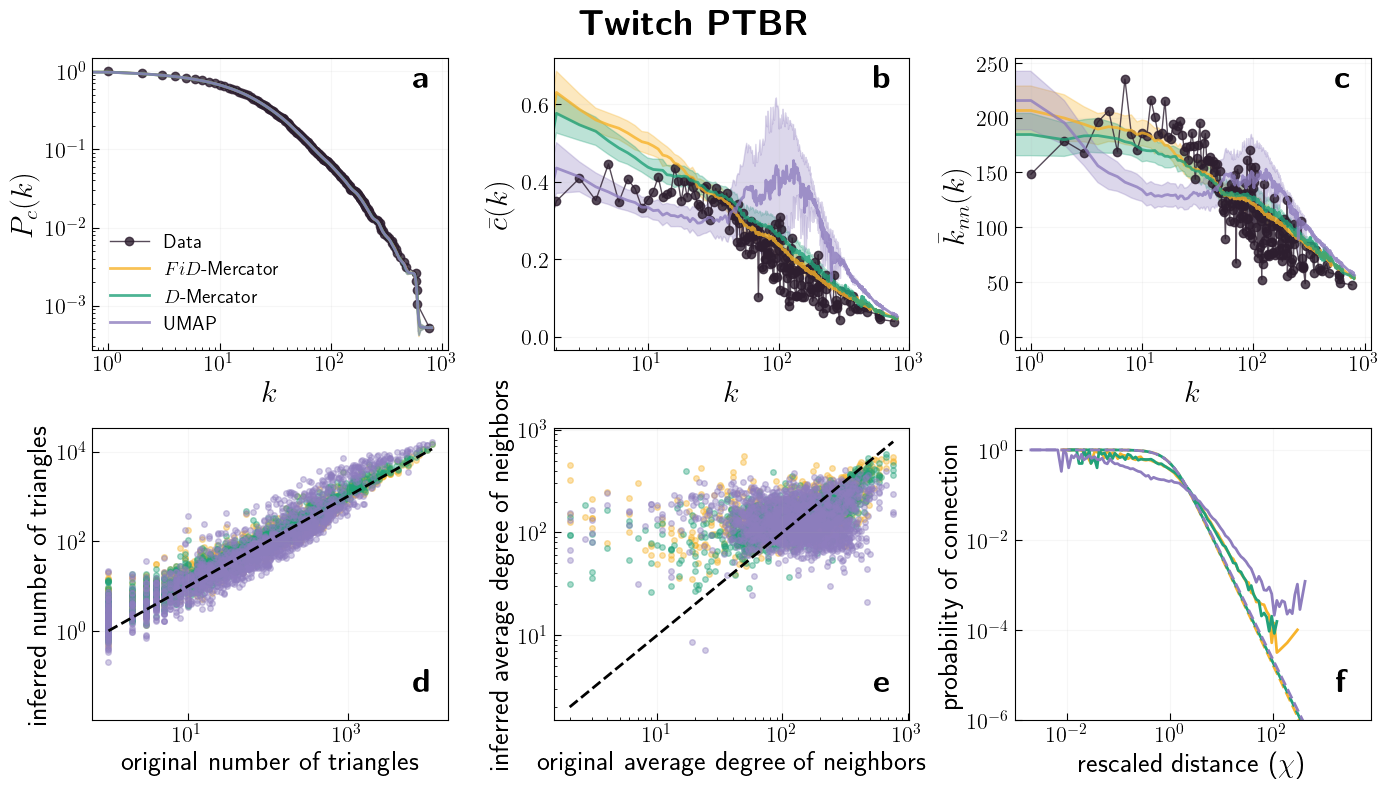

In [62]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/random/"

filename = 'musae_PTBR_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(14, 8))
plt.subplot(2, 3, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)
plt.text(0.9, 0.9, r'$\textbf{a}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 1000)
plt.text(0.9, 0.9, r'$\textbf{b}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 3)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')
plt.text(0.9, 0.9, r'$\textbf{c}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 4)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{d}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 5)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{e}$', fontsize=24, transform=plt.gca().transAxes)

plt.subplot(2, 3, 6)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')
plt.text(0.9, 0.1, r'$\textbf{f}$', fontsize=24, transform=plt.gca().transAxes)

plt.suptitle(r'\textbf{Twitch PTBR}', fontsize=26, y=0.98)
plt.tight_layout()

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/ReSubmission_npjC/Paper/SI/plots/topological_properties_twitch_ptbr_new.png", dpi=300)


---
---
---
---
# Old figures 

Text(0.5, 0.93, '\\textbf{Citeseer}')

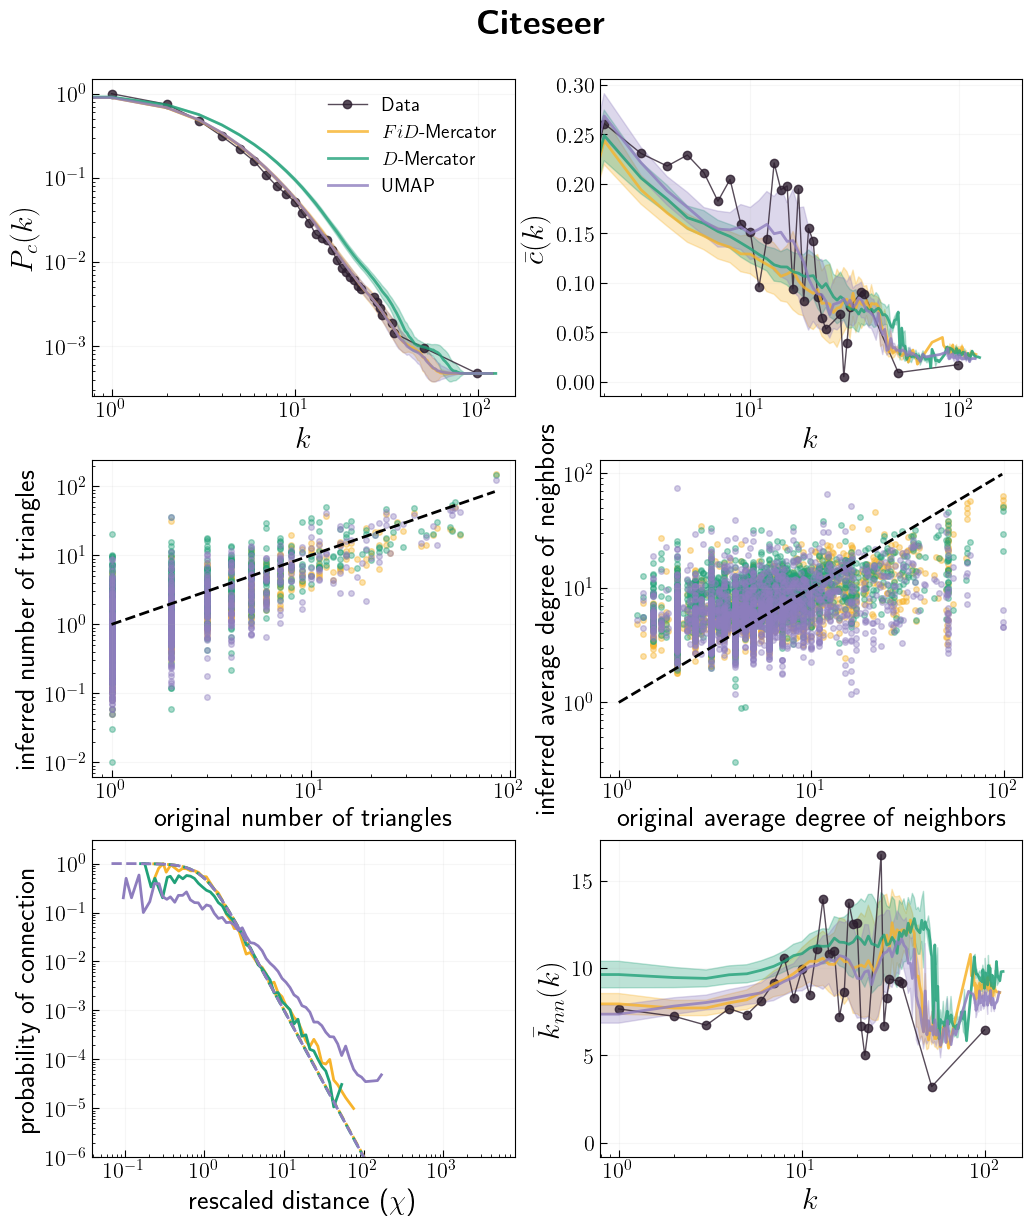

In [4]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/only_umap/"
#path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/citeseer/umap/random/"

filename = 'citeseer_GC_fixed'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')


plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Citeseer}', fontsize=25, y=0.93)
# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_citeseer.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_citeseer.png", dpi=300)


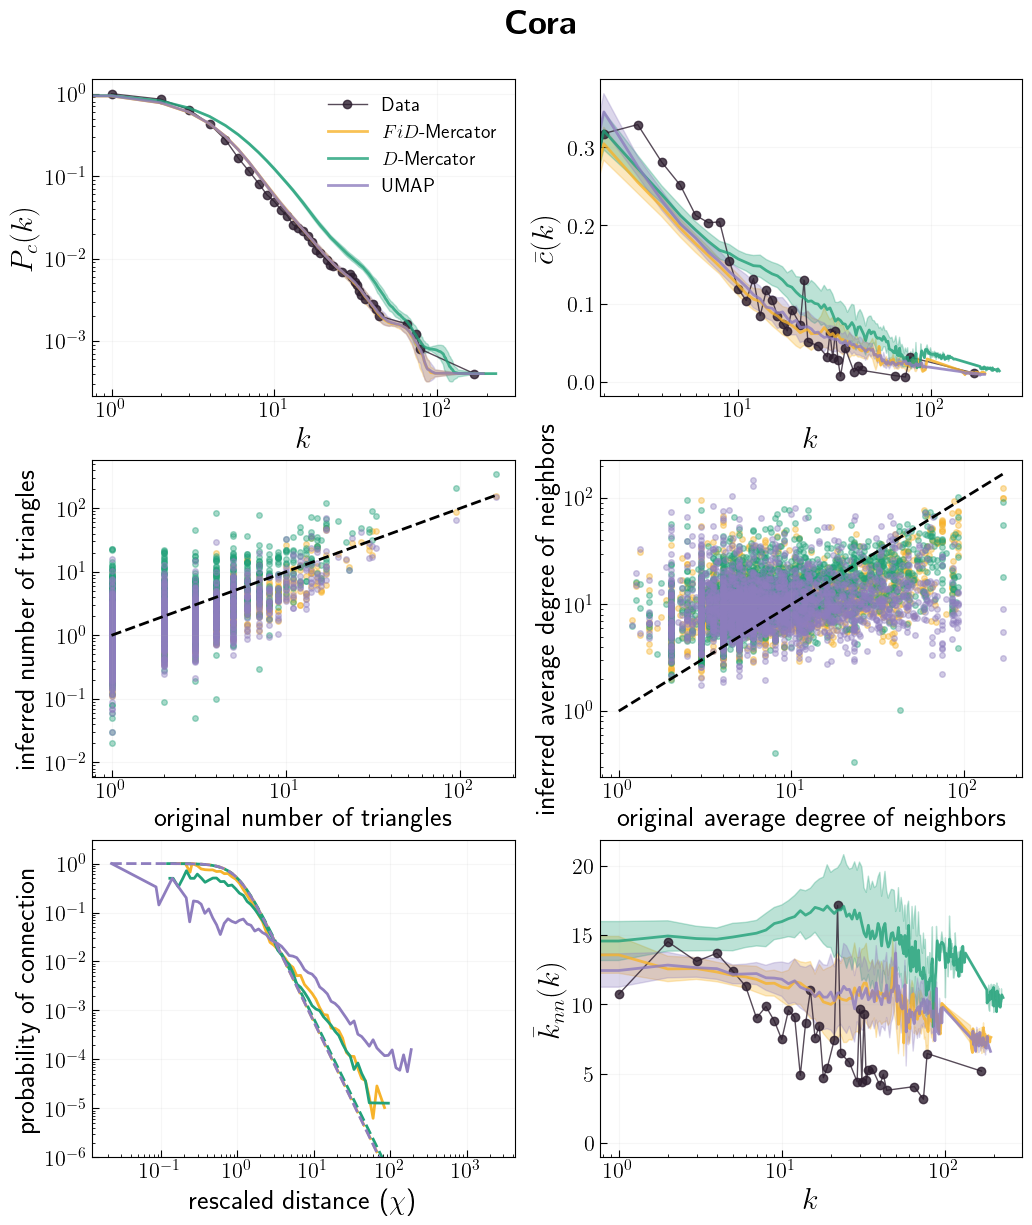

In [7]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/cora/umap/random/"

filename = 'cora_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 300)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')


plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Cora}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_cora.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_cora.png", dpi=300)


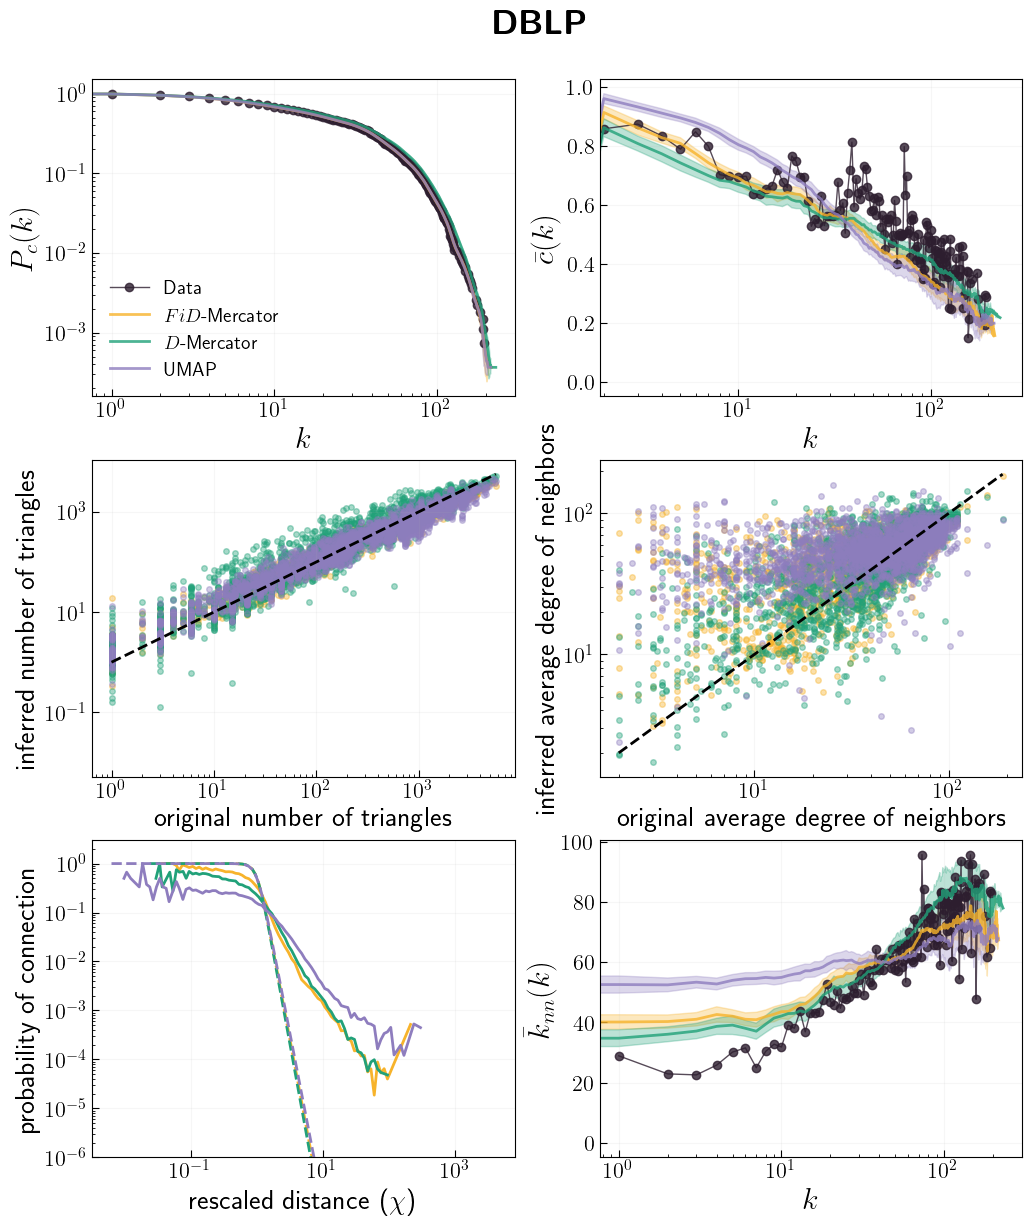

In [9]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/dblp/umap/random/"

filename = 'dblp_pprefp_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 300)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')


plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{DBLP}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_dblp.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_dblp.png", dpi=300)


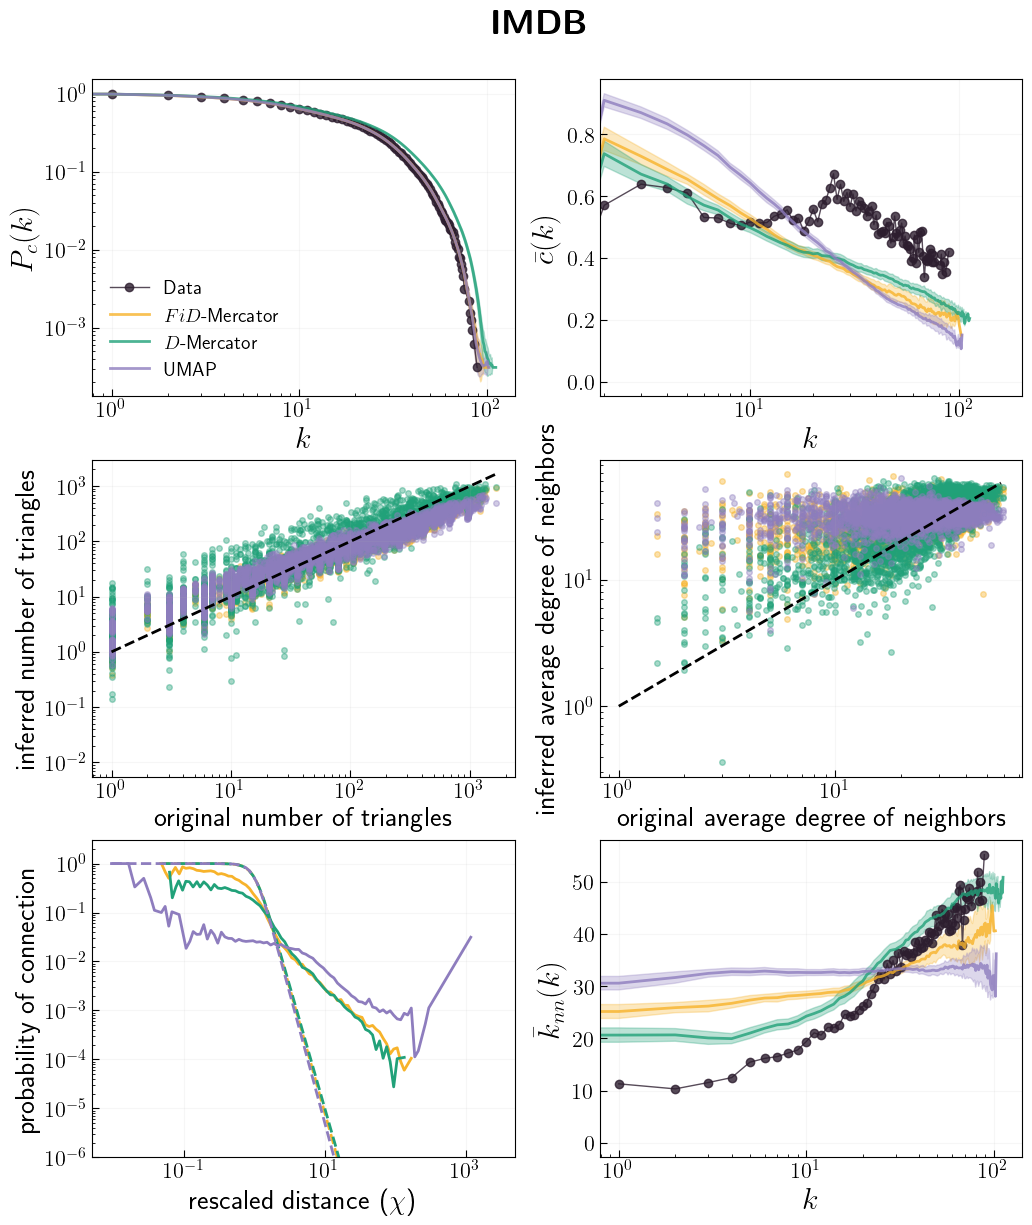

In [10]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/imdb/umap/random/"
filename = 'imdb_mam_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')


plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{IMDB}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_imdb.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_imdb.png", dpi=300)


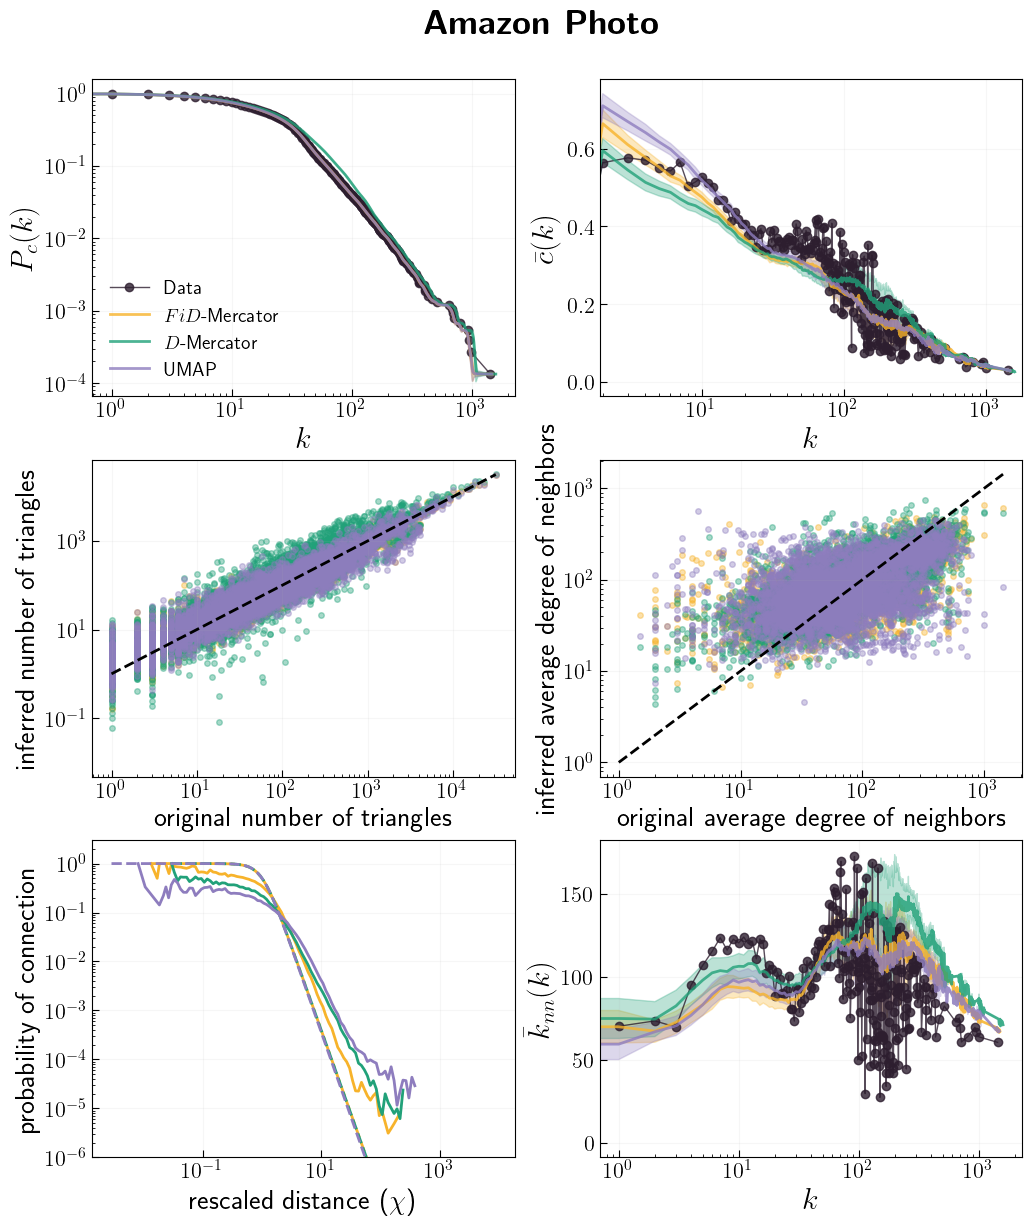

In [11]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/amazon_photo/umap/random/"
filename = 'amazon_photo_GC'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 1800)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Amazon Photo}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_amazon_photo.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_amazon_photo.png", dpi=300)


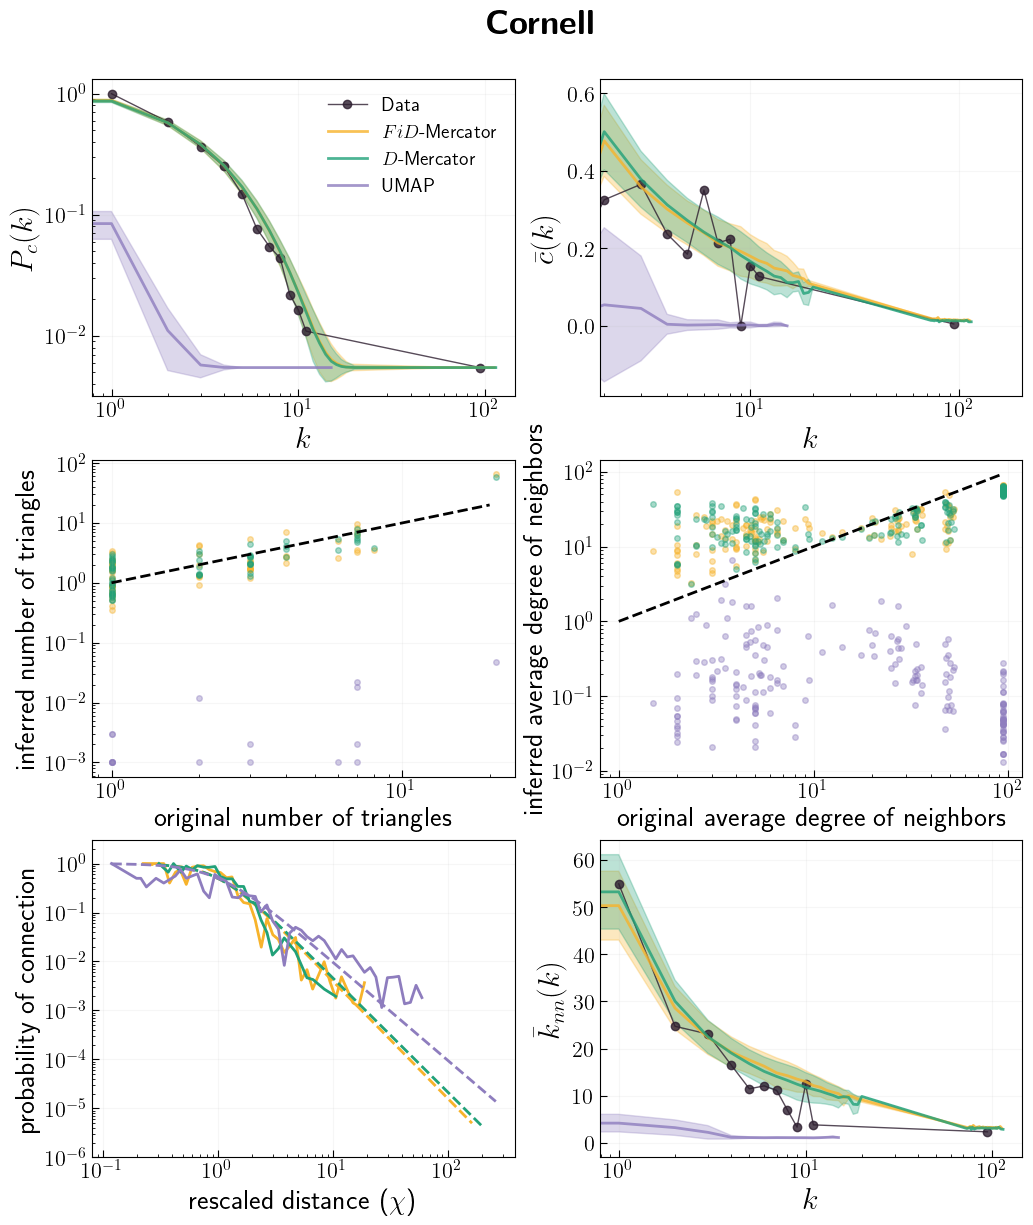

In [12]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/cornell/umap/random/"
filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Cornell}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_cornell.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_cornell.png", dpi=300)


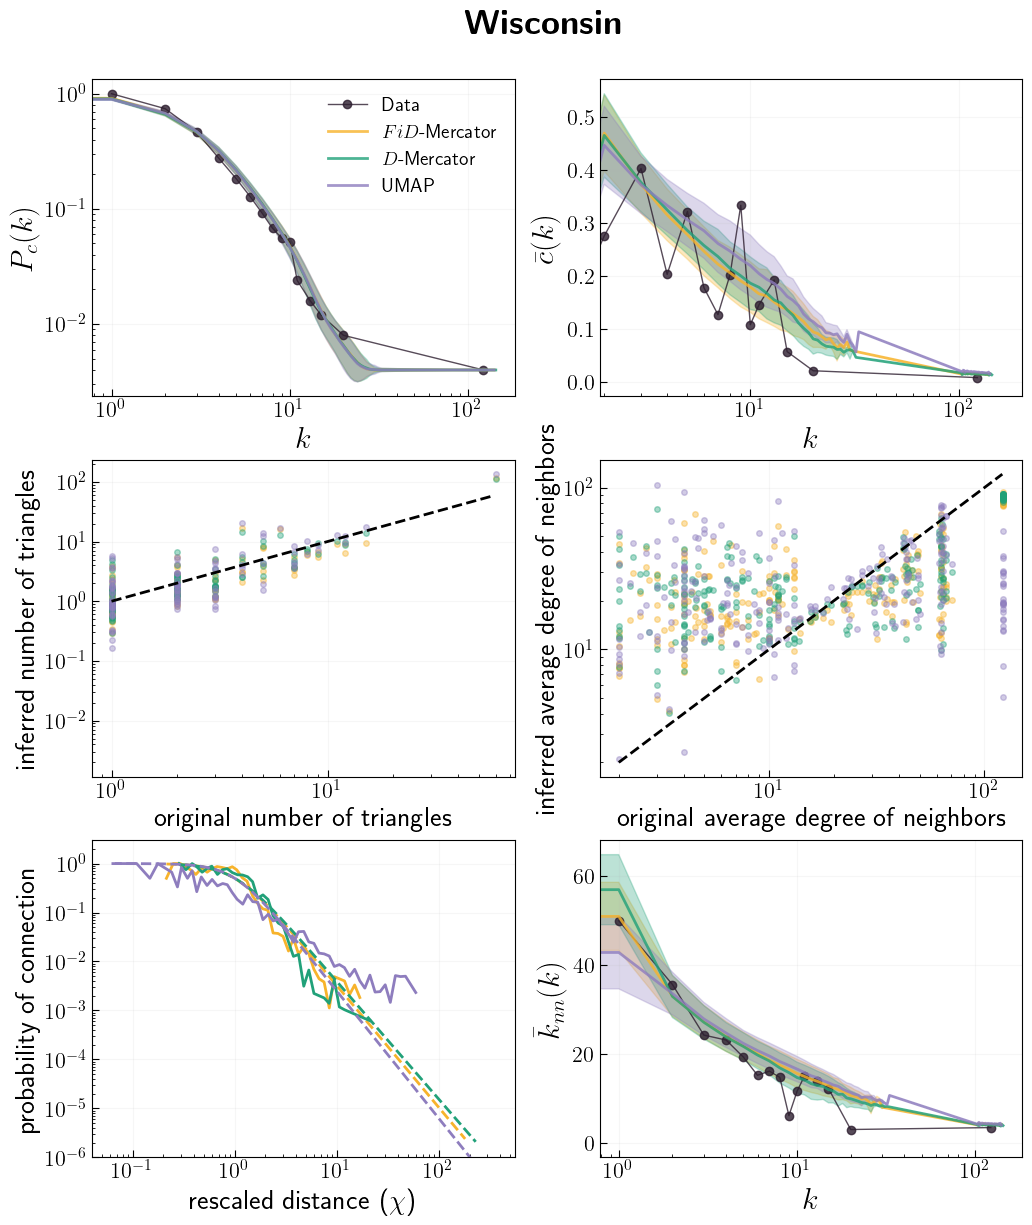

In [13]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/wisconsin/umap/random/"
filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Wisconsin}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_wisconsin.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_wisconsin.png", dpi=300)


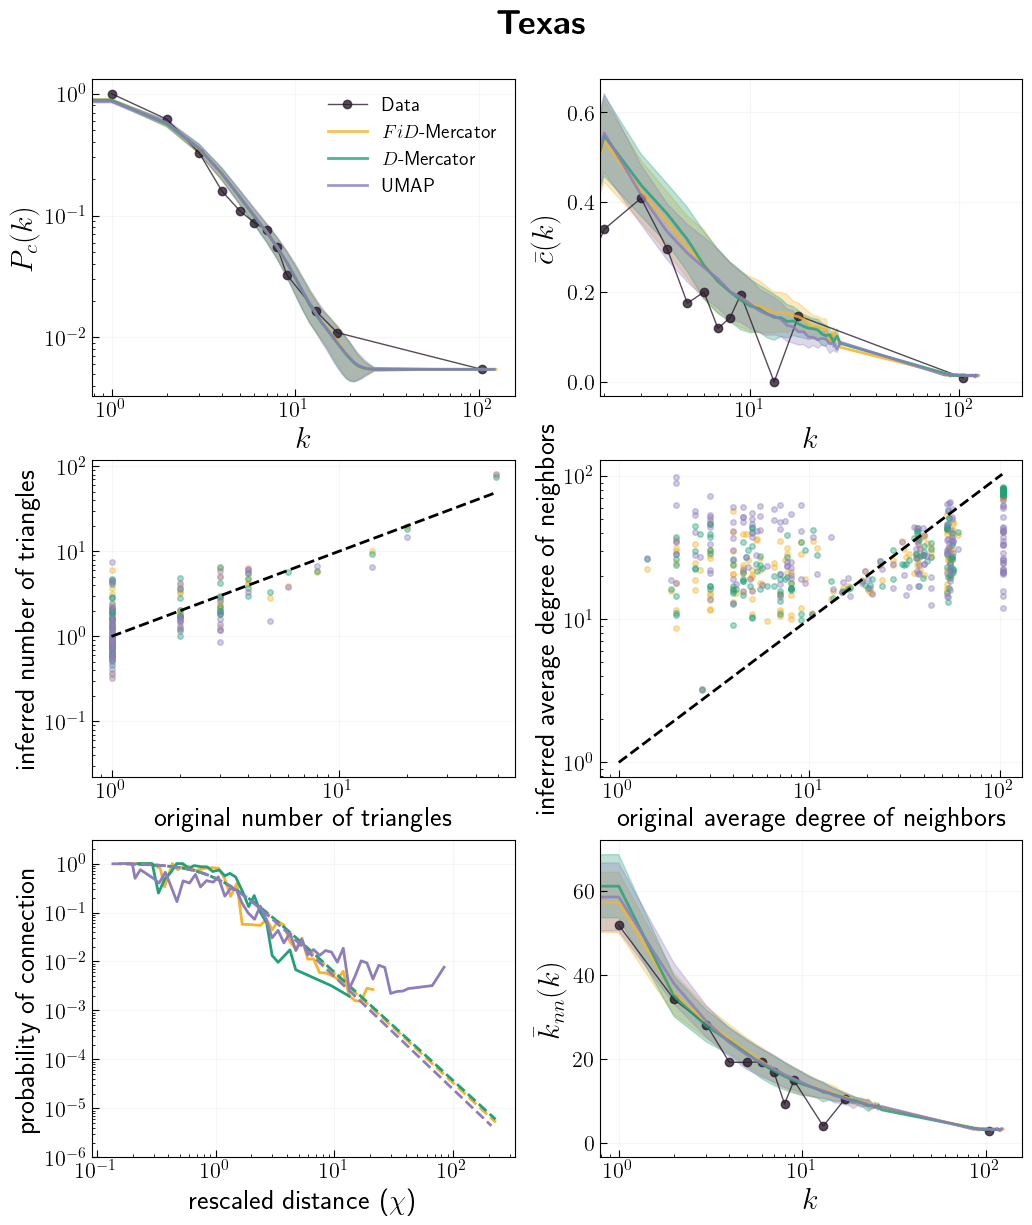

In [14]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/webkb/texas/umap/random/"
filename = 'out1_graph_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 200)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Texas}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_texas.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_texas.png", dpi=300)


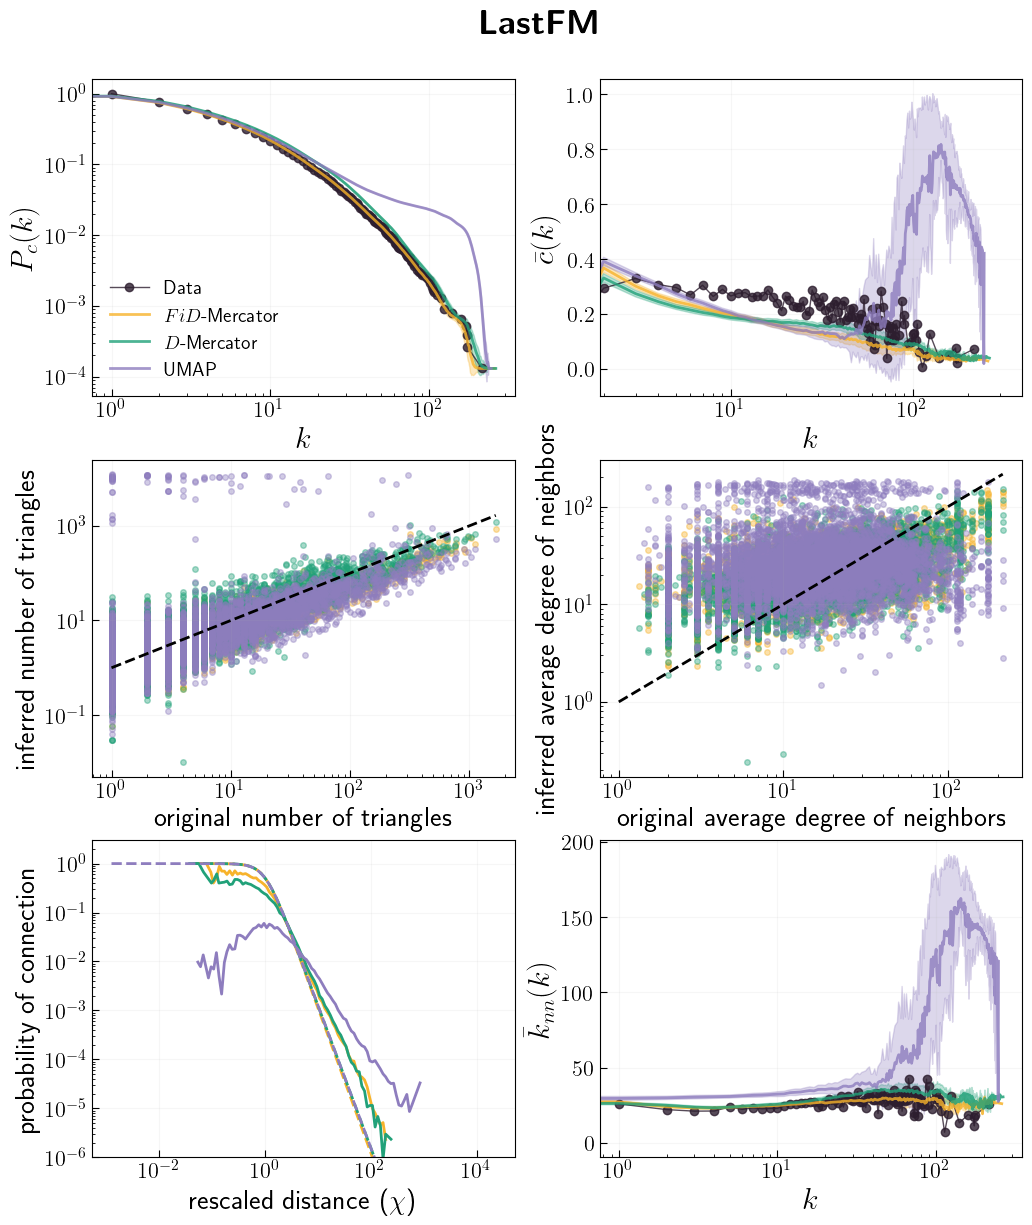

In [15]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/lastfm_asia/umap/random/"
filename = 'lastfm_asia_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 400)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{LastFM}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_lastfm.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_lastfm.png", dpi=300)


In [ ]:
path1 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/umap_ml/"
path2 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/le_ml/"
path3 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/only_umap/"
# path4 = "/home/rob/MEGAsync/datasets/networks/machine_learning_datasets/f_mercator/twitch/PTBR/umap/random/"
filename = 'musae_PTBR_edges'

paths = [path1, path2, path3]

labels = [r'$FiD$-Mercator', r'$D$-Mercator', 'UMAP']

dfs_vstats = [load_vstats(p, filename) for p in paths]
df_obs = load_vstat_obs(path1, filename)
df_vprop = [load_vprops(p, filename) for p in paths]
df_pconns = [load_pcon(p, filename) for p in paths]

#########################
plt.figure(figsize=(12, 14))
plt.subplot(3, 2, 1)
plot_degree_distribution(df_obs, dfs_vstats, labels)
plt.legend(fontsize=14)

plt.subplot(3, 2, 2)
plot_clustering_coefficient(df_obs, dfs_vstats, labels)
plt.legend('')
plt.xlim(1.9, 400)

plt.subplot(3, 2, 3)
plot_number_of_triangles(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 4)
plot_sum_degree_neighbours(df_vprop, labels)
plt.legend('')

plt.subplot(3, 2, 5)
plot_connection_probabilities(df_pconns, labels)
plt.legend('')

plt.subplot(3, 2, 6)
plot_average_degree_neighbour(df_obs, dfs_vstats, labels)
plt.legend('')

plt.suptitle(r'\textbf{Twitch PTBR}', fontsize=25, y=0.93)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Report/figures-publication-and-random-initialization-27-04-23/plots/topological_properties_twitch_ptbr.png", dpi=300)

# plt.savefig("/home/rob/Dropbox/NodesFeaturesEmbeddings/Paper/SI/plots/topological_properties_twitch_ptbr.png", dpi=300)

